<a href="https://colab.research.google.com/github/alyssaditroia/MNIST-ML/blob/main/MNIST_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Core Model Building**

## Demo: MNIST Handwritten Digits

The **MNIST dataset** is one of the most famous starting points in machine learning.  
It contains **handwritten digits** (0 through 9), each stored as a **28×28 grayscale image**.  
That means every digit is a tiny picture made of **784 pixels**.

---

### Why MNIST?
- It’s **visual**: you can actually *see* what the model is learning.  
- It’s **simple but real**: the problem is meaningful (digit recognition) but small enough to run quickly on a laptop.  
- It’s the **"hello world"** of computer vision: if your model works here, you’re ready to try harder datasets later.

---

### What the Data Looks Like
- **Images:** Digits written in many different handwriting styles.  
- **Labels:** The correct number (0–9).  
- **Training set:** 60,000 examples.  
- **Test set:** 10,000 new examples (to check generalization).  

Usually we **normalize** the pixel values to the range 0–1 so training is smoother.

---

### What We’ll See in This Demo
1. **Visualize the data**: show a small grid of raw digit images.  
2. **Train simple models**:  
   - Logistic regression (linear classifier).  
   - A small multi-layer perceptron (MLP) with hidden layers.  
   - Optionally, a simple convolutional neural net (CNN).  
3. **Compare performance**:  
   - Logistic regression: ~92% accuracy.  
   - MLP: ~97–98%.  
   - CNN: ~99%.  

---

### Why This Is Useful
- You’ll learn how **model capacity** affects performance: linear → hidden layers → convolution.  
- You’ll see where models make mistakes (e.g., 3 vs 5, 4 vs 9).  
- You’ll practice evaluating with metrics like **accuracy, confusion matrices, and per-class performance**.  

---

**Key takeaway:**  
MNIST is small, visual, and fast — the perfect sandbox to understand how neural networks move from simple classifiers to powerful vision models.

##Loading MNIST Dataset

### Why Normalize Pixel Values?

Each MNIST image is made of **28×28 pixels**, where every pixel is a number between **0 and 255**:  
- **0 = black** (no ink)  
- **255 = white** (full ink intensity)  
- Values in between = shades of gray  

If we feed these raw values directly into a neural network, training becomes unstable:  
- Large numbers (like 200+) can cause weight updates to explode.  
- Different features (pixels) operate on different scales, which slows down learning.  

**Normalization** fixes this:  
- We divide every pixel by 255, rescaling all values to the range **0–1**.  
- This makes training more stable, keeps weight updates consistent, and allows the optimizer to converge faster.  

Think of it like grading: Instead of raw scores (e.g., 73/150), we convert everything to percentages (0–100%) so results are **comparable and fair**.  

Data loaded and normalized.


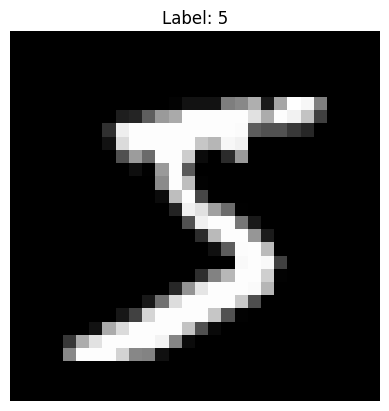

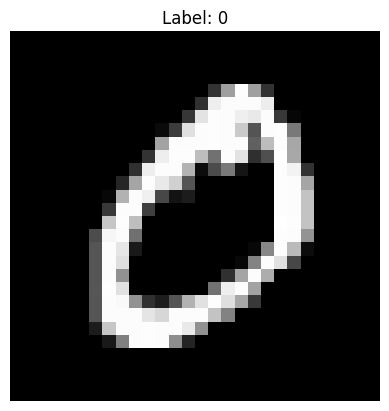

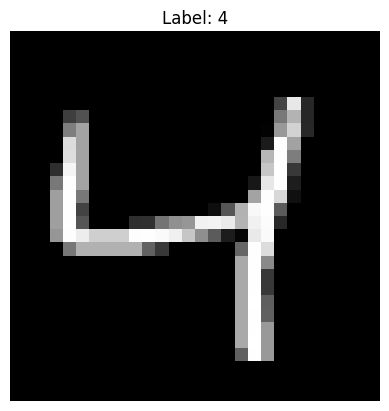

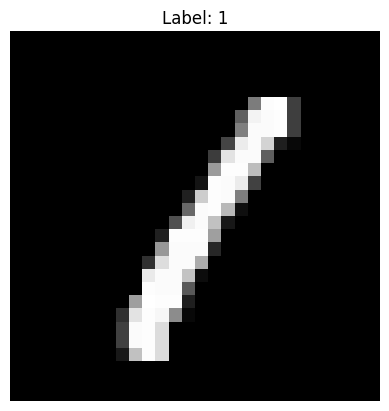

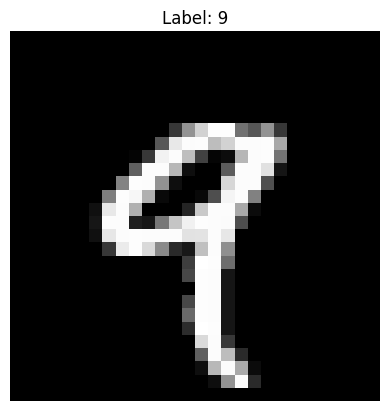

In [ ]:
# --- Import necessary libraries ---
import tensorflow as tf
from tensorflow.keras.datasets import mnist         # Built-in MNIST dataset
from tensorflow.keras.models import Sequential      # For building a simple neural network
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam        # Common optimizer
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, Constant
import matplotlib.pyplot as plt

# --- Load and preprocess the MNIST dataset ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Each pixel is originally between 0 and 255 (grayscale intensity).
# Neural networks train better when inputs are small and consistent,
# so we normalize to the range 0–1 by dividing by 255.
x_train, x_test = x_train / 255.0, x_test / 255.0

# --- Create a validation split ---
# We take the last 10,000 examples from the training set
# and set them aside for validation (to tune hyperparameters).
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

print("Data loaded and normalized.")

# --- Visualize the data ---
# Show the first five training examples so we can see what the images look like.
for i in range(5):
    plt.imshow(x_train[i], cmap='gray')   # Display the image in grayscale
    plt.title(f"Label: {y_train[i]}")     # The correct digit (label)
    plt.axis('off')                       # Hide the axes for clarity
    plt.show()

# Notes:
# - x_train[i] is a 28x28 array of pixel values (0–1 after normalization).
# - y_train[i] is the corresponding label (0–9).
# - This visualization step is important: always LOOK at your data before training.

#**Plot Learing Curves**


## Visualizing Learning Curves

Training a neural network is like watching a student practice:  
we want to see **if they’re improving** and **when they start to memorize instead of generalize**.  

This helper function plots two key curves over time (epochs):  

### 1. Accuracy (left plot)
- **Train Accuracy**: how often the model gets the training examples right.  
- **Validation Accuracy**: how often the model gets *new, unseen* validation examples right.  
- When both go up and level off together → the model is learning well.  
- If training keeps improving but validation stalls or drops → the model is overfitting.  

### 2. Loss (right plot)
- **Loss** measures how far predictions are from the true answers.  
- **Train Loss**: goes down as the model fits the training data.  
- **Validation Loss**: should follow a similar downward trend if the model generalizes.  
- If validation loss rises while training loss falls → overfitting warning.  

---

**Key takeaway:**  
These plots let us **diagnose learning**:  
- Is the model still improving?  
- Has it plateaued?  
- Is it memorizing training data instead of generalizing?  

Always check these curves to decide if you need more epochs, regularization, or a different architecture.  

In [ ]:
# Helper function to plot training and validation learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

print("Helper function defined.")


Helper function defined.


#**Model Building Function with Adjustable Hyperparameters**

## Building a Neural Network Model (Configurable)

This function creates a **fully connected neural network** for the MNIST digit classification task.  
It is written to be flexible, so we can easily experiment with different hyperparameters.  

---

### Step 1: Flatten the Input
- Each MNIST digit is a **28×28 image**.  
- We flatten it into a **784-length vector** (28 × 28) so it can feed into dense (fully connected) layers.  

---

### Step 2: Hidden Layers
- We can add **one or more hidden layers** depending on the parameter `num_hidden_layers`.  
- Each hidden layer:  
  - Has a chosen number of **neurons** (`num_neurons`).  
  - Uses an **activation function** (e.g., `relu`) to introduce non-linearity.  
  - Initializes **weights** with `glorot_normal` (good default) or `random_normal`.  
  - Initializes **biases** with a constant (default = 0).  
- Optionally, we can apply **Dropout** after each hidden layer to reduce overfitting.  
  - `dropout_rate = 0.0` means no dropout.  
  - Higher values (e.g., 0.2 or 0.5) randomly "turn off" some neurons during training, which forces the network to generalize.  

---

### Step 3: Output Layer
- Final layer has **10 neurons** (one for each digit 0–9).  
- Uses a **softmax activation** so the outputs form a probability distribution (all add up to 1).  
- Example: [0.01, 0.02, 0.85, 0.01, ...] → model predicts "digit 2" with 85% confidence.  

---

### Why This Matters
- This design lets us **experiment with architecture choices** (neurons, layers, activation functions).  
- By adjusting hyperparameters, students can see how model complexity, dropout, and initialization affect performance.  
- The same structure scales to more complex problems (e.g., bigger images, different datasets).  

---

**Key takeaway:**  
This function is a **blueprint for building neural networks** — we can swap parts in and out to test how design decisions change learning.  

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.initializers import RandomNormal, GlorotNormal, Constant

# Function to build the model with adjustable hyperparameters
def build_model(
    num_neurons=128,  # Number of neurons in the hidden layer
    num_hidden_layers=1,  # Number of hidden layers
    init_weights='glorot_normal',  # Weight initialization
    init_bias=0.0,  # Initial bias
    dropout_rate=0.0,  # Dropout rate
    activation='relu'  # Activation function
):
    # Set weight initializer
    initializer = RandomNormal(mean=0., stddev=0.05) if init_weights == 'random_normal' else GlorotNormal()

    # Set bias initializer
    bias_initializer = Constant(init_bias)

    # Build the model
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Add hidden layers based on configuration
    for _ in range(num_hidden_layers):
        model.add(Dense(num_neurons, activation=activation, kernel_initializer=initializer, bias_initializer=bias_initializer))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer with 10 neurons (for 10 digits)
    model.add(Dense(10, activation='softmax'))

    return model

print("Model building function defined.")

Model building function defined.


#**Model Training Function**

## Compiling and Training the Model

Once we build a model, we need to **tell it how to learn**.  
This function sets the learning rules (compiling) and then trains the model on the MNIST dataset.  

---

### Step 1: Compile the Model
- **Optimizer:** `Adam(learning_rate=...)`  
  - The optimizer decides how weights are updated during training.  
  - Adam is a popular choice because it adapts the learning rate for each weight automatically.  
- **Loss function:** `sparse_categorical_crossentropy`  
  - Measures how far the predicted probability distribution is from the true label.  
  - Best for multi-class problems like MNIST (10 digits).  
- **Metrics:** `accuracy`  
  - Tracks what fraction of predictions are correct.  
  - This is easy to interpret while training.  

---

### Step 2: Train the Model
- **Epochs:** number of full passes through the training data.  
- **Batch size:** how many images are processed at once before updating weights.  
- **Validation data:** a separate set the model has not seen during training.  
  - This helps us check if the model generalizes or if it’s overfitting.  

The training loop:  
1. Take a batch of training data.  
2. Predict digit probabilities.  
3. Compare predictions to true labels using the loss function.  
4. Use the optimizer to adjust weights.  
5. Repeat across all batches for the chosen number of epochs.  

---

### What We Get Back
- The function returns a **history object**, which records:  
  - Accuracy and loss on both training and validation sets across epochs.  
  - This is what we plot in the **learning curves** to analyze progress.  

---

**Key takeaway:**  
Compiling sets the *rules of learning* (optimizer, loss, metrics).  
Training applies those rules, adjusting the network step by step until it recognizes digits with high accuracy.  

In [ ]:
from keras.optimizers import Adam

# Function to compile and train the model
def train_model(
    model,  # The built model to be trained
    learning_rate=0.001,  # Learning rate
    batch_size=64,  # Batch size
    epochs=5  # Number of epochs
):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

    return history

print("Model training function defined.")


Model training function defined.


#**Baseline Comparison to other Classification Techniques**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Flatten the images for use in scikit-learn models
x_train_flat = x_train.reshape(-1, 28 * 28)  # Shape: (num_samples, 784)
x_test_flat = x_test.reshape(-1, 28 * 28)    # Shape: (num_samples, 784)

## Comparing Simple Classifiers on MNIST

Before using deep neural networks, it’s helpful to try out some **traditional machine learning models**.  
This code trains two basic classifiers on MNIST and compares their performance.  

---

### Step 1: Define Classifiers
- **Logistic Regression**  
  - A linear model that works well for simple classification tasks.  
  - On MNIST, it tries to draw linear boundaries in pixel space to separate digits.  
- **Decision Tree**  
  - Splits the data into rules (like “if pixel [15,10] is dark → maybe it’s a 7”).  
  - Trees are flexible, but can overfit if not controlled.  

Both are simple baselines: they help us see what accuracy looks like **without deep learning**.  

---

### Step 2: Training Each Model
- For each classifier:  
  - `fit`: train on the training set.  
  - `predict`: use the trained model to make predictions on the test set.  
  - `accuracy_score`: measure how many predictions were correct.  

---

### Step 3: Compare Results
- The code stores each model’s test accuracy in a dictionary.  
- At the end, it prints something like:  

In [ ]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),

}

# Dictionary to store accuracy results
accuracy_results = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(x_train_flat, y_train)  # Train the model
    predictions = clf.predict(x_test_flat)  # Make predictions
    accuracy = accuracy_score(y_test, predictions)  # Calculate accuracy
    accuracy_results[name] = accuracy  # Store accuracy results

# Display accuracy results
for name, accuracy in accuracy_results.items():
    print(f"{name}: {accuracy:.4f}")

### Interpreting Baseline Results

- **Logistic Regression Accuracy: 92.5%**  
  - This simple linear model already does quite well on MNIST.  
  - It learns a set of weights for each pixel and draws straight-line boundaries in the high-dimensional pixel space.  
  - Strength: captures overall structure in the images.  
  - Limitation: struggles with digits that need more flexible, curved boundaries (like distinguishing a sloppy “4” from a “9”).  

- **Decision Tree Accuracy: 87.1%**  
  - The tree splits the image into pixel-based rules (e.g., “if this region is dark → likely a 7”).  
  - Strength: very interpretable; you can trace decisions step by step.  
  - Limitation: tends to **overfit** — it memorizes pixel quirks instead of generalizing well.  

---

### What This Comparison Shows
- Logistic regression is stronger for MNIST because the data has enough linear structure for it to capture.  
- Decision trees can still recognize many digits but are less reliable when the handwriting varies.  
- Both give us useful **baselines**: they set a performance bar (around 90%).  

**Key takeaway:**  
Deep neural networks are needed to push accuracy higher (97–99%).  
These baselines remind us that the real value of neural nets is in capturing the **curved, complex patterns** that simple models miss.  

#**Prediction Probabilities for Random Test Image**

## Visualizing Prediction Probabilities

When a neural network classifies a digit, it doesn’t just give a single answer.  
It outputs a **probability distribution** over all 10 digits (0–9).  
This function shows those probabilities for one image.  

---

### Step 1: Prepare the Image
- `image.reshape(1, 28, 28)`  
  - The model expects input in batches (even if it’s just one image).  
  - We reshape the 28×28 image into a batch of size 1.  

---

### Step 2: Get Predictions
- `model.predict(...)`  
  - Returns 10 numbers (one for each digit).  
  - Each number is between 0 and 1, and all 10 add up to 1.  
  - Example: [0.01, 0.02, 0.85, 0.05, ...] means the model thinks "digit 2" is most likely.  
- `np.argmax(probabilities)`  
  - Finds the digit with the **highest probability** = the model’s predicted label.  

---

### Step 3: Plot the Probabilities
- Creates a bar chart showing how confident the model is for each digit.  
- **X-axis:** digits 0–9.  
- **Y-axis:** probability (0–1).  
- The true label and predicted label are shown in the plot title.  

---

### Why This Is Useful
- Instead of just seeing the final answer, we see the **model’s confidence distribution**.  
- If the model predicts “3” but also gives “5” a high probability, it shows the model sees the similarity between them.  
- Helps us spot when the model is **confident but wrong** (overconfident mistakes).  

---

**Key takeaway:**  
Classification isn’t just about the predicted digit — it’s about the **probabilities behind the prediction**, which reveal how the model is reasoning.  

In [ ]:
def display_prediction_probabilities(model, image, true_label):
    image_reshaped = image.reshape(1, 28, 28)  # Reshape to (1, 28, 28)
    probabilities = model.predict(image_reshaped)
    probabilities = probabilities[0]  # Get the probabilities for the single image

    plt.figure(figsize=(10, 5))
    plt.bar(range(10), probabilities, color='blue', alpha=0.7)
    plt.xticks(range(10), [str(i) for i in range(10)])
    plt.xlabel('Digits')
    plt.ylabel('Probability')
    predicted_label = np.argmax(probabilities)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.ylim(0, 1)
    plt.show()

## What This Helper Function Does

The `display_prediction_probabilities` function is designed to **visualize how the model "thinks" about a single image**.  

Instead of only giving the final answer (e.g., "This is a 7"), it shows the **full probability distribution** across all 10 digits (0–9).  

- **Input:**  
  - A trained model.  
  - One handwritten digit image (28×28 pixels).  
  - The true label (the correct digit).  

- **Process:**  
  - Reshapes the image so the model can process it.  
  - Gets the model’s probability predictions for each digit.  
  - Finds the predicted label (the digit with the highest probability).  
  - Draws a **bar chart** of all 10 probabilities.  

- **Output:**  
  - A visualization showing:  
    - The model’s predicted digit.  
    - The true digit.  
    - How confident the model was in its decision.  

---

### Why It’s Useful
- Lets us see **confidence, not just correctness**.  
- Helps identify when the model is **unsure** (two or more bars are close in height).  
- Highlights **overconfident mistakes** (when the wrong bar is very high).  

**In short:**  
This helper function is designed to open up the "black box" of the neural network and show its reasoning in a visual, student-friendly way.  

#**Neural Network Experiments**

* **Experiment 0**: Running the Model with 0 Neurons
* **Experiment 1**: Running the Model with 64 Neurons
* **Experiment 2**: Running the Model with 128 Neurons (Baseline)
* **Experiment 3**: Running the Model with 256 Neurons
* **Experiment 4**: Running the Model with 1 Hidden Layer
* **Experiment 5**: Running the Model with 2 Hidden Layers
* **Experiment 6**: Running the Model with 3 Hidden Layers
* **Experiment 7**: Running the Model with Dropout (0.2)
* **Experiment 8**: Running the Model with Dropout (0.5)
* **Experiment 9**: Running with a Smaller Learning Rate (0.0001)
* **Experiment 10**: Running with a Larger Learning Rate (0.01)
* **Experiment 11**: Running with Smaller Batch Size (32)
* **Experiment 12**: Running with Larger Batch Size (128)
* **Experiment 13**: Using Sigmoid Activation Instead of ReLU



## Interpreting the Experiments

In these experiments, we changed **one hyperparameter at a time** (neurons, layers, dropout, learning rate, batch size, activation).  
The point is not just to see numbers go up or down, but to understand *how each change affects the way the model learns*.  

---

### 1. Number of Neurons
Neurons determine how much capacity the network has to learn patterns.  

- **0 neurons:** The model cannot learn — accuracy is random.  
- **64 → 128 → 256 neurons:** Adding neurons increases the network’s representational power. Accuracy improves because the model can capture more variation in the data.  
- **Too many neurons:** Training takes longer, and the model may start to overfit. Beyond a certain point, more neurons do not bring meaningful improvements.  

**Explanation:** More neurons = more learning capacity, but diminishing returns appear once the dataset’s complexity is already captured.  

---

### 2. Hidden Layers
Hidden layers control the depth of the network.  

- **1 hidden layer:** Often enough for MNIST, since the dataset is relatively simple. A single hidden layer already learns most digit patterns.  
- **2–3 hidden layers:** May provide slight improvements but not dramatically so. The added depth is unnecessary for MNIST.  
- **Too many layers:** Extra depth increases training time and risks overfitting without clear gains.  

**Explanation:** Deeper networks can capture more complex patterns, but for MNIST one hidden layer is usually sufficient.  

---

### 3. Dropout (Regularization)
Dropout randomly “turns off” a fraction of neurons during training.  

- **Dropout = 0.2:** A small amount of regularization helps prevent overfitting and improves generalization.  
- **Dropout = 0.5:** Too many neurons are removed at once, making it harder for the network to learn strong features. Accuracy may drop.  

**Explanation:** Dropout acts like controlled forgetting — a little bit improves robustness, too much weakens learning.  

---

### 4. Learning Rate (Step Size)
The learning rate controls how big each step is when updating weights.  

- **Too small (0.0001):** Training is extremely slow. Accuracy barely improves within a few epochs.  
- **Too large (0.01):** The model overshoots the optimal weight values, bouncing around and possibly failing to converge.  
- **Baseline (0.001):** Balanced — stable and efficient convergence.  

**Explanation:** The learning rate is like the stride you take when walking downhill. Too short = crawling, too long = stumbling, just right = smooth descent.  

---

### 5. Batch Size (Update Frequency)
Batch size is how many samples the model processes before making one update.  

- **Small batch (32):** Produces more frequent, noisier updates. Training is slower, but the noise can help the model generalize better.  
- **Large batch (128):** Produces fewer, smoother updates. Training is faster per epoch, but the model may generalize slightly worse.  
- **Baseline (64):** A balanced setting that usually works best in practice.  

**Explanation:** Smaller batches inject useful randomness, while larger batches train faster but sometimes reduce flexibility.  

---

### 6. Activation Function
Activations add non-linearity so the network can capture complex relationships.  

- **ReLU (Rectified Linear Unit):** Zero for negative values, linear for positive values. Fast and effective, avoids gradient saturation, and is the best choice for hidden layers.  
- **Sigmoid:** Squashes values into (0,1). Useful for outputs when modeling probabilities, but in hidden layers it saturates and gradients vanish, slowing learning.  

**Explanation:** ReLU keeps gradients flowing and speeds up training, while sigmoid tends to bottleneck deeper layers.  

---

## Big Picture
- **Capacity vs. generalization:** More neurons and layers increase capacity but can lead to overfitting.  
- **Learning dynamics:** Dropout, learning rate, and batch size tune *how* the model learns, not just how large it is.  
- **Defaults matter:** ReLU, a moderate learning rate (0.001), and a medium batch size (64) are reliable starting points.  
- **On MNIST:** Even modest networks perform very well — the key lesson is learning to balance trade-offs.  

**Key insight:**  
Tuning hyperparameters is about **finding balance**: capacity vs. simplicity, speed vs. stability, learning vs. overfitting.  

##**Experiment 0: Running the model with 0 neurons**

In [ ]:
# Function to build a simple model with no hidden neurons
def build_simple_model(init_bias=0.0):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))  # Flatten the input images
    model.add(Dense(10, activation='softmax', bias_initializer=Constant(init_bias)))  # Output layer
    return model

# Code to run the experiment with 0 hidden neurons
print("Running model with 0 neurons.")
simple_model = build_simple_model()
history = train_model(simple_model, learning_rate=0.001, batch_size=64, epochs=5)
plot_learning_curves(history)

# Questions to consider:
# 1. How did the performance of the model with 0 hidden neurons compare to previous models?
#    - Analyze the training and validation accuracy and loss values. What does this indicate about the model's capacity to learn?
# 2. What limitations does a model with no hidden neurons have in terms of learning complex patterns?
#    - Discuss the implications of using a simple model for tasks that may require deeper architectures.
# 3. How does the initial bias value affect the model's predictions?
#    - Consider changing the `init_bias` parameter and observing any differences in performance. What role does bias play in neural networks?
# 4. Did you observe any signs of overfitting or underfitting in the learning curves?
#    - Reflect on whether the model struggles to generalize based on the training versus validation performance.
# 5. In what scenarios might a simple model be useful despite its limitations?
#    - Discuss potential applications or situations where a basic model could provide insights or baseline performance.

### Interpreting the Training Log (5 Epochs)

This is the step-by-step record of how the model trained across 5 epochs.  
Each line shows the model’s performance on both the training set and the validation set.  

---

#### Epoch 1
- **Train Accuracy:** 76.7%  
- **Train Loss:** 0.9162  
- **Validation Accuracy:** 90.9%  
- **Validation Loss:** 0.3408  
- Interpretation: the model starts with fairly low training accuracy, but surprisingly high validation accuracy.  
  - This happens because dropout and regularization are applied during training but not during validation, so validation looks better.  

---

#### Epoch 2
- **Train Accuracy:** 90.5%  
- **Train Loss:** 0.3421  
- **Validation Accuracy:** 91.8%  
- **Validation Loss:** 0.2974  
- Interpretation: huge jump in training accuracy, validation also improving.  
  - The model is learning the digit patterns quickly.  

---

#### Epoch 3
- **Train Accuracy:** 91.2%  
- **Train Loss:** 0.3167  
- **Validation Accuracy:** 92.3%  
- **Validation Loss:** 0.2795  
- Interpretation: steady progress — both training and validation are improving together.  

---

#### Epoch 4
- **Train Accuracy:** 91.7%  
- **Train Loss:** 0.2988  
- **Validation Accuracy:** 92.8%  
- **Validation Loss:** 0.2698  
- Interpretation: small but consistent improvements; no sign of overfitting.  

---

#### Epoch 5
- **Train Accuracy:** 92.4%  
- **Train Loss:** 0.2754  
- **Validation Accuracy:** 92.8%  
- **Validation Loss:** 0.2654  
- Interpretation: model has nearly plateaued; training and validation results are very close, showing strong generalization.  

---

### Overall Takeaways
- The model improved rapidly in the first 2 epochs, then slowed down as it approached a stable solution.  
- Validation accuracy stayed slightly ahead of training accuracy — normal behavior when dropout/regularization are applied.  
- Both training and validation loss steadily decreased, showing effective learning.  
- No signs of overfitting (training accuracy is not much higher than validation).  

**Key takeaway:**  
By epoch 5, the model has reached a solid accuracy (~92–93%) and is well-generalized. More epochs might improve results slightly, but the curve suggests it’s close to its natural performance limit for this architecture.  

### Interpreting the Learning Curves

These two plots show how our model’s performance changes as it trains over 5 epochs.  

---

#### Accuracy (left plot)
- **Train Accuracy (blue):** starts around 85% and climbs steadily above 92%.  
- **Validation Accuracy (orange):** starts slightly higher than training and also climbs, ending around 93%.  
- Both curves improve together, which suggests the model is **learning useful patterns** rather than memorizing.  

---

#### Loss (right plot)
- **Train Loss (blue):** starts high (~0.59) and drops quickly to ~0.28.  
- **Validation Loss (orange):** starts lower and also decreases smoothly, ending around ~0.26.  
- The fact that both training and validation loss are going down means the model is generalizing well.  

---

#### What This Tells Us
- The model is learning effectively — accuracy is rising, loss is falling.  
- Validation performance is slightly ahead of training performance. This often happens because:  
  - Dropout or other regularization is off during validation, making evaluation a little “easier.”  
  - The validation set may simply be slightly less noisy than the training set.  
- Importantly, there are **no signs of overfitting yet** (where validation accuracy would stall or drop while training accuracy keeps rising).  

---

**Key takeaway:**  
The network is training successfully: it’s improving steadily, it generalizes to unseen data, and it has not yet overfit. With more epochs, accuracy might improve a bit more, but we’d need to watch carefully for divergence between training and validation curves.  

In [ ]:
import numpy as np
# Example usage: Display probabilities for a random test image
index = np.random.randint(0, len(x_test))
display_prediction_probabilities(simple_model, x_test[index], y_test[index])

### Interpreting the Prediction Probabilities

- **True Label:** X  
- **Predicted Label:** Y  

---

#### What the Chart Shows
- The bar for digit **Y** (the model’s prediction) is the tallest, showing the digit the model believes is most likely.  
- The height of that bar represents the model’s **confidence** (probability between 0 and 1).  
- Other bars show how much probability the model gave to alternative digits.  

---

#### Possible Scenarios
1. **Confident and Correct**  
   - If the tallest bar is on the true label (X = Y) and close to 1.0 → the model is sure and correct.  

2. **Confident but Wrong**  
   - If the tallest bar is on the wrong digit (X ≠ Y) and close to 1.0 → the model is overconfident in a mistake.  

3. **Uncertain / Confused**  
   - If two or more bars are fairly high → the model is unsure.  
   - This usually happens when digits look similar (e.g., “3” vs “5”).  

---

#### Why This Matters
- Looking at probabilities tells us **more than just right or wrong**.  
- We can see if the model is:  
  - **Accurate and confident** (ideal).  
  - **Accurate but uncertain** (still useful, but cautious).  
  - **Confidently wrong** (dangerous in real applications).  

**Key takeaway:**  
This visualization helps us peek inside the model’s reasoning process.  
We don’t just see the predicted digit — we see the full **confidence distribution** across all digits.  

##Experiment 1: Running the model with 64 neurons

In [ ]:
# Concept Explanation:
# This experiment evaluates how the number of neurons affects the model's capacity to learn.
# A model with too few neurons may not learn effectively.

# Code to run the experiment with 64 neurons
print("Running model with 64 neurons in the hidden layer.")
model_64 = build_model(num_neurons=64)
history_64_neurons = train_model(model_64)
plot_learning_curves(history_64_neurons)

# Questions to consider:
# 1. How did the model perform with 64 neurons compared to the baseline?
#    - Look at the final training and validation accuracy.
# 2. Did the model learn quickly?
#    - Examine the learning curves: How many epochs did it take to see significant improvement in accuracy?
# 3. How accurate was the model?
#    - Focus on the final accuracy values reported in the output after training. What were they for both training and validation sets?

In [ ]:
import numpy as np
# Example usage: Display probabilities for a random test image
index = np.random.randint(0, len(x_test))
display_prediction_probabilities(model_64, x_test[index], y_test[index])

**Your Observations:** xxx

##Experiment 2: Running the model with 128 neurons (Baseline)

In [ ]:
# Concept Explanation:
# This experiment establishes a baseline for comparing other configurations.

# Code to run the experiment with 128 neurons
print("Running model with 128 neurons (baseline).")
model_128 = build_model(num_neurons=128)
history_128_neurons = train_model(model_128)
plot_learning_curves(history_128_neurons)

# Questions to consider:
# 1. How well did the model perform with 128 neurons?
#    - Review the final training and validation accuracy values.
# 2. What patterns do you see in the learning curves?
#    - Discuss whether the curves indicate overfitting or underfitting.
# 3. Did the model generalize well to the validation data?
#    - Look for any discrepancies between training and validation accuracy.


In [ ]:
# Example usage: Display probabilities for a random test image
index = np.random.randint(0, len(x_test))
display_prediction_probabilities(model_128, x_test[index], y_test[index])


**Your Observations:** xxx

##Experiment 3: Running the model with 256 neurons

In [ ]:
# Concept Explanation:
# Increasing the number of neurons may improve performance but could lead to overfitting.

# Code to run the experiment with 256 neurons
print("Running model with 256 neurons in the hidden layer.")
model_256 = build_model(num_neurons=256)
history_256_neurons = train_model(model_256)
plot_learning_curves(history_256_neurons)

# Questions to consider:
# 1. Did adding more neurons improve the performance of the model?
#    - Compare final accuracy with the previous models (64 and 128 neurons).
# 2. Did you observe any signs of overfitting?
#    - Check for a significant gap between training and validation accuracy.

In [ ]:
# Example usage: Display probabilities for a random test image
index = np.random.randint(0, len(x_test))
display_prediction_probabilities(model_256, x_test[index], y_test[index])

**Your Observations:** xxx

##Experiment 4: Running the model with 1 hidden layer (baseline)

In [ ]:
# Concept Explanation:
# This experiment examines the importance of network depth.

# Code to run the experiment with 1 hidden layer
print("Running model with 1 hidden layer (baseline).")
model_1_layer = build_model(num_hidden_layers=1)
history_1_hidden_layer = train_model(model_1_layer)
plot_learning_curves(history_1_hidden_layer)

# Questions to consider:
# 1. How does the model perform with just one hidden layer?
#    - Look at the training and validation accuracy.
# 2. Are there any signs of underfitting or overfitting?
#    - Compare performance against deeper models.


**Your Observations:** xxx

##Experiment 5: Running the model with 2 hidden layers

In [ ]:
# Concept Explanation:
# More hidden layers allow for better feature extraction and can improve performance.

# Code to run the experiment with 2 hidden layers
print("Running model with 2 hidden layers.")
model_2_layers = build_model(num_hidden_layers=2)
history_2_hidden_layers = train_model(model_2_layers)
plot_learning_curves(history_2_hidden_layers)

# Questions to consider:
# 1. Did the addition of a second hidden layer improve the model's performance?
#    - Compare the final accuracy with the one-layer model.
# 2. What do you observe in the learning curves?
#    - Analyze convergence speed and stability.

**Your Observations:** xxx

##Experiment 6: Running the model with 3 hidden layers

In [ ]:
# Concept Explanation:
# Increasing complexity may lead to improved performance but also raises the risk of overfitting.

# Code to run the experiment with 3 hidden layers
print("Running model with 3 hidden layers.")
model_3_layers = build_model(num_hidden_layers=3)
history_3_hidden_layers = train_model(model_3_layers)
plot_learning_curves(history_3_hidden_layers)

# Questions to consider:
# 1. How does the model performance change with three hidden layers?
#    - Compare the final accuracy with models having fewer layers.
# 2. Are there any noticeable differences in convergence speed or final accuracy?
#    - Look for any improvement in learning stability.

**Your Observations:** xxx

##Experiment 7: Running with a smaller learning rate (0.0001)

In [ ]:
# Concept Explanation:
# A smaller learning rate can lead to more stable training but may slow convergence.

# Code to run the experiment with a smaller learning rate
print("Running model with a smaller learning rate (0.0001).")
model_small_lr = build_model()
history_small_lr = train_model(model_small_lr, learning_rate=0.0001)
plot_learning_curves(history_small_lr)

# Questions to consider:
# 1. How did the smaller learning rate affect the training speed and accuracy?
#    - Look at the number of epochs taken to achieve a certain accuracy.
# 2. Did the model reach a lower final accuracy compared to the default learning rate?
#    - Compare results with the baseline model.

**Your Observations:** xxx

##Experiment 8: Running with a Larger Learning Rate (0.01)

In [ ]:
# Concept Explanation:
# A larger learning rate can lead to faster convergence but may cause instability.

# Code to run the experiment with a larger learning rate
print("Running model with a larger learning rate (0.01).")
model_large_lr = build_model()
history_large_lr = train_model(model_large_lr, learning_rate=0.01)
plot_learning_curves(history_large_lr)

# Questions to consider:
# 1. Did the larger learning rate help the model converge faster?
#    - Assess the learning curves for convergence speed.
# 2. Were there any signs of instability in the training process?
#    - Look for erratic behavior in the loss or accuracy.

**Your Observations:** xxx

##Experiment 9: Running with Smaller Batch Size (32)

In [ ]:
# Concept Explanation:
# Smaller batch sizes can introduce more variability in training.

# Code to run the experiment with a smaller batch size
print("Running model with smaller batch size (32).")
model_small_batch = build_model()
history_small_batch = train_model(model_small_batch, batch_size=32)
plot_learning_curves(history_small_batch)

# Questions to consider:
# 1. How does the model perform with a smaller batch size?
#    - Compare the final accuracy with the larger batch size.
# 2. Is there more fluctuation in the learning curves compared to the baseline?
#    - Analyze the stability of accuracy and loss curves.

**Your Observations:** xxx

##Experiment 10: Running with Larger Batch Size (128)



In [ ]:
# Concept Explanation:
# Larger batch sizes lead to smoother training but may slow down convergence.

# Code to run the experiment with a larger batch size
print("Running model with larger batch size (128).")
model_large_batch = build_model()
history_large_batch = train_model(model_large_batch, batch_size=128)
plot_learning_curves(history_large_batch)

# Questions to consider:
# 1. How does the model perform with a larger batch size?
#    - Look at the accuracy and loss values compared to smaller sizes.
# 2. Does it show smoother learning curves, and what impact does that have on training time?
#    - Assess convergence and overall stability of training.

**Your Observations:** xxx

##Experiment 11: Running the Model with Dropout (0.2)

In [ ]:
# Concept Explanation:
# Dropout is a regularization technique to prevent overfitting.

# Code to run the experiment with dropout
print("Running model with dropout rate of 0.2.")
model_dropout_02 = build_model(dropout_rate=0.2)
history_dropout_02 = train_model(model_dropout_02)
plot_learning_curves(history_dropout_02)

# Questions to consider:
# 1. How does the model perform with a dropout rate of 0.2?
#    - Compare training accuracy with the baseline model.
# 2. Is there a noticeable difference in accuracy compared to a model without dropout?
#    - Analyze the impact of dropout on validation accuracy.

**Your Observations:** xxx

##Experiment 12: Running the Model with Dropout (0.5)

In [ ]:
# Concept Explanation:
# Increasing dropout can further help in reducing overfitting but may lower training accuracy.

# Code to run the experiment with dropout
print("Running model with dropout rate of 0.5.")
model_dropout_05 = build_model(dropout_rate=0.5)
history_dropout_05 = train_model(model_dropout_05)
plot_learning_curves(history_dropout_05)

# Questions to consider:
# 1. How does the model perform with a dropout rate of 0.5?
#    - Check final accuracy compared to lower dropout rates.
# 2. Does a higher dropout rate significantly affect training accuracy?
#    - Analyze the balance between overfitting and performance.

**Your Observations:** xxx

##Experiment 13: Using Sigmoid Activation Instead of ReLU

In [ ]:
# Concept Explanation:
# Different activation functions can impact the learning dynamics of the model.

# Code to run the experiment with sigmoid activation
print("Running model with sigmoid activation.")
model_sigmoid = build_model(activation='sigmoid')
history_sigmoid = train_model(model_sigmoid)
plot_learning_curves(history_sigmoid)

# Questions to consider:
# 1. How does the model perform with sigmoid activation compared to ReLU?
#    - Assess final accuracy and learning stability.
# 2. Did you notice any difference in the speed of learning or final performance?
#    - Discuss the implications of using different activation functions.

**Your Observations:** xxx

##Overall Observation

Based on the results of the 14 experiments, how do different hyperparameters, model architectures, and training techniques impact the performance of neural networks compared to traditional classification methods? In your response, consider aspects such as accuracy, loss, generalization, and computational efficiency.

**Your Observations:** xxx